# Setup

In [1]:
import json
import base64
import plotly.io as pio
import plotly
from IPython.display import display, HTML

def json_to_encoded(data):
    return base64.b64encode(json.dumps(data).encode()).decode()
    
def plot_to_json(fig):
    return pio.to_json(fig)

In [2]:
from huggingface_hub import login, whoami

login()

In [3]:
import pandas as pd
DATASET_PATH = 'derek-thomas/embedding-ie-optimization'
df = pd.read_parquet(f"hf://datasets/{DATASET_PATH}/data/train-00000-of-00001.parquet")

df.columns

Index(['total_requests', 'test_duration_sec', 'successful_requests',
       'avg_latency_ms', 'p95_latency_ms', 'throughput_req_per_sec',
       'avg_embedding_size', 'hw_type', 'batch_size', 'image', 'engine',
       'vendor', 'vus', 'seconds_per_billion', 'cost_per_sec', '1B_cost'],
      dtype='object')

# Best Runs

In [4]:
df[['1B_cost', 'hw_type', 'batch_size', 'vus', ]].sort_values(by='1B_cost').head()

,1B_cost,hw_type,batch_size,vus
64,409.436780,nvidia-l4,32,256
63,412.699969,nvidia-l4,32,512
62,416.307301,nvidia-l4,32,384
61,417.812902,nvidia-l4,32,319
56,418.356886,nvidia-l4,32,257


# Sanity Checks

## Did we have any failed requests?
We should expect to see `0` here if all our requests were successful.

In [5]:
sum(df.total_requests - df.successful_requests)

0

## Are we getting the expected embedding size?
We should see only 1 value here.

Min	768
Max	768


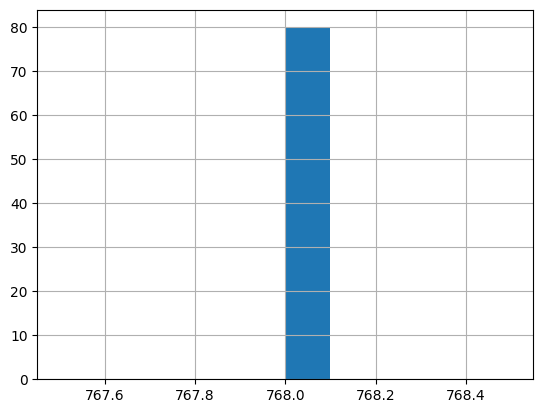

In [6]:
df.avg_embedding_size.hist(bins=10)
print(f"Min\t{df.avg_embedding_size.min()}")
print(f"Max\t{df.avg_embedding_size.max()}")

## Did we try enough VUs?
How do we know that we tried enough VUs? What if we tried a higher amount of VUs and throughput kept increasing? If thats the case then we would see a monotonicly increasing relationship between VUs and Throughput and we would need to run more tests. Lets check this out!

We can check by:
1. **Grouping data** by `hw_type` and `batch_size` to match how we generated the experiments
1. **Sorting the data** by `vus` within each group to ensure we get the data in the correct order for our check
1. **Check for monotonic increase** in `throughput_req_per_sec` flag the groups that always increase throughput as VUs increase


Note: do a sanity check with the following code to make sure that this does indeed detect if it does in-fact detect the series you expect.
```python
df_filtered = df[df['vus'] <= 256]`
grouped = df_filtered.groupby(['hw_type', 'batch_size'])
```


In [7]:
md = """## Did we try enough VUs?
How do we know that we tried enough VUs? What if we tried a higher amount of VUs and throughput kept increasing? If thats the case then we would see a monotonicly increasing relationship between VUs and Throughput and we would need to run more tests. Lets check this out!

We can check by:
1. **Grouping data** by `hw_type` and `batch_size` to match how we generated the experiments
1. **Sorting the data** by `vus` within each group to ensure we get the data in the correct order for our check
1. **Check for monotonic increase** in `throughput_req_per_sec` flag the groups that always increase throughput as VUs increase

But how do we **know**? We can use the slider to check what would have happened if we had not tried past a certain amount. Lets say that if we tried 256 instead of our actual 1024 we would have left some potential on the table, we can simulate this by filtering our runs. 

### Verification
1. Put the slider at `256` and see that there are a number of scenarios where we should have checked for a higher VU count
1. Put the slider at `1024 and verify that there are no scenarios shown
"""
encoded_df = json_to_encoded(df.to_json())
encoded_md = json_to_encoded(md)

code = f'''
<html>
	<head>
		<script type="module" crossorigin src="https://cdn.jsdelivr.net/npm/@gradio/lite/dist/lite.js"></script>
		<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@gradio/lite/dist/lite.css" />
	</head>
	<body>
		<gradio-lite>
import gradio as gr
import pandas as pd
import plotly.express as px
import json
import base64

# Define base64 encoded string at the beginning
encoded_df = "{encoded_df}"
encoded_md = "{encoded_md}"

decoded_df = json.loads(base64.b64decode(encoded_df).decode())
decoded_md = json.loads(base64.b64decode(encoded_md).decode())
df = pd.read_json(decoded_df)

def filter_dataframe(vus_filter):
    return df[df['vus'] <= vus_filter]

def get_monotonic_dataframe(vus_filter):
    df_filtered = filter_dataframe(vus_filter)
    grouped = df_filtered.groupby(['hw_type', 'batch_size'])
    
    monotonic_series = {{}}
    for (hw_type, batch_size), group in grouped:
        group_sorted = group.sort_values('vus').reset_index(drop=True)
        if group_sorted['throughput_req_per_sec'].is_monotonic_increasing:
            monotonic_series[(hw_type, batch_size)] = group_sorted[['vus', 'throughput_req_per_sec']]
    
    if not monotonic_series:
        return pd.DataFrame(columns=['hw_type', 'batch_size'])
    
    results_df = pd.DataFrame([(hw_type, batch_size) for (hw_type, batch_size) in monotonic_series.keys()],
                              columns=['hw_type', 'batch_size'])
    return results_df

with gr.Blocks() as demo:
    gr.Markdown(decoded_md)
    vus_slider = gr.Slider(minimum=0, maximum=df['vus'].max(), value=1024, label="VUs Filter")
    
    
    @gr.render(inputs=vus_slider)
    def plot_monotonic_series(vus_filter):
        results_output = gr.Dataframe(value=get_monotonic_dataframe(vus_filter))
        df_filtered = filter_dataframe(vus_filter)
        grouped = df_filtered.groupby(['hw_type', 'batch_size'])
        
        monotonic_series = {{}}
        for (hw_type, batch_size), group in grouped:
            group_sorted = group.sort_values('vus').reset_index(drop=True)
            if group_sorted['throughput_req_per_sec'].is_monotonic_increasing:
                monotonic_series[(hw_type, batch_size)] = group_sorted[['vus', 'throughput_req_per_sec']]
        
        if not monotonic_series:
            gr.Markdown("### No monotonically increasing series found.")
        else:
            gr.Markdown("### Plots of Monotonic Series")
            for (hw_type, batch_size), data in monotonic_series.items():
                fig = px.line(data, x='vus', y='throughput_req_per_sec', markers=True,
                              title=f'Throughput Trend for HW: {{hw_type}}, Batch: {{batch_size}}')
                gr.Plot(fig)

demo.launch()

<gradio-requirements>
plotly=={plotly.__version__}
</gradio-requirements>
        </gradio-lite>
	</body>
</html>'''

# Display the interactive app inside Jupyter Notebook
display(HTML(code))


# Analysis

## 1B Cost vs. Latency Scatter Plot

In [8]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Get the 100 lowest-cost points
bottom_100 = df.nsmallest(100, "1B_cost").copy()
bottom_100["1B_cost"] = bottom_100["1B_cost"].round(2)
bottom_100["throughput_req_per_sec"] = bottom_100["throughput_req_per_sec"].round(2)
bottom_100["avg_latency_ms"] = bottom_100["avg_latency_ms"].round(3)

# Find the global minimum cost point *only within* the bottom 100 points
global_min = bottom_100.nsmallest(1, "1B_cost")

# Function to find Pareto-efficient points (minimizing cost and latency)
def pareto_efficient(df, x_col, y_col):
    sorted_df = df.sort_values(by=[x_col, y_col])  # Sort by latency, then cost
    pareto_points = []
    min_cost = np.inf  # Start with a very high cost
    
    for _, row in sorted_df.iterrows():
        if row[y_col] < min_cost:  # If this cost is the lowest seen so far
            pareto_points.append(row)
            min_cost = row[y_col]
    
    return pd.DataFrame(pareto_points)

# Compute Pareto front
pareto_front = pareto_efficient(bottom_100, "avg_latency_ms", "1B_cost")

# Base scatter plot (showing 100 lowest-cost points)
fig = px.scatter(
    bottom_100, 
    x="avg_latency_ms", 
    y="1B_cost", 
    symbol="hw_type", 
    color="batch_size",  
    color_continuous_scale="viridis",  
    opacity=0.7, 
    title="1B Requests Cost/day vs. Latency<br><sup>Pareto-efficient points and global min highlighted</sup>",
    labels={
        "avg_latency_ms": "Average Latency (ms)",
        "1B_cost": "Daily Cost ($)",
        "hw_type": "Hardware Type",
        "batch_size": "Batch Size",
    },
    hover_data=["vus", "batch_size", "throughput_req_per_sec"]
)

# Add global minimum cost point (red star)
fig.add_trace(
    go.Scatter(
        x=global_min["avg_latency_ms"],
        y=global_min["1B_cost"],
        mode="markers",
        marker=dict(size=12, color="red", symbol="star", line=dict(width=2, color="black")),
        name="Global Min Cost",
        hovertemplate="Latency: %{x} ms<br>Cost: $%{y}<br>Batch Size: %{text}<br>VUs: %{customdata[0]}<br>Throughput: %{customdata[1]} req/sec",
        text=global_min["batch_size"],
        customdata=global_min[["vus", "throughput_req_per_sec"]].values,
        showlegend=False
    )
)

# Add Pareto curve with detailed hover info
fig.add_trace(
    go.Scatter(
        x=pareto_front["avg_latency_ms"],
        y=pareto_front["1B_cost"],
        mode="lines+markers",
        line=dict(color="red", width=2, dash="dash"),
        marker=dict(size=6, color="red"),
        name="Pareto Front",
        hovertemplate="Latency: %{x} ms<br>Cost: $%{y}<br>Batch Size: %{text}<br>VUs: %{customdata[0]}<br>Throughput: %{customdata[1]} req/sec",
        text=pareto_front["batch_size"],
        customdata=pareto_front[["vus", "throughput_req_per_sec"]].values,
        showlegend=False
    )
)

# Adjust layout (Center title)
fig.update_layout(
    title_x=0.5,  # Centers title
    legend=dict(
        x=1,  
        y=1.2,  
        title="Hardware Type"
    )
);

# fig.show()


In [9]:
md = """## 1B Requests Cost vs. Latency

This scatter plot visualizes the relationship between **average latency (ms)** and **cost per billion requests per day** for different **hardware types (hw_type)** and **image processing configurations (image)**.

### How to Read the Chart:
- **Point Symbols**: Represent different **hardware + image** configurations.
- **Color Gradient**: Represents batch size, helping to see cost trends across different batch sizes.
- **Hover Data**: Displays additional details like **VUs, batch size, and throughput per second**.

### Key Features:
- **Global Minimum Cost (Red Star)**: Marks the configuration with the lowest cost.
- **Pareto Front (Red Dashed Line + Points)**: Highlights the most efficient configurations, minimizing both cost and latency. These configurations offer the best trade-offs.

### How to Use:
- Find the **lowest-cost, low-latency configurations** by looking at points near the bottom-left.
- Use the **Pareto front** to identify cost-effective configurations.
- Compare different **hardware and image processing strategies** to optimize your setup.

This visualization helps in selecting the best configuration balancing **performance (low latency)** and **cost efficiency**.

"""
json_fig = plot_to_json(fig)
encoded_fig = json_to_encoded(json_fig)
encoded_md = json_to_encoded(md)

# Define HTML content
code = f'''
<html>
	<head>
		<script type="module" crossorigin src="https://cdn.jsdelivr.net/npm/@gradio/lite/dist/lite.js"></script>
		<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@gradio/lite/dist/lite.css" />
	</head>
	<body>
		<gradio-lite>
import json
import gradio as gr
import base64
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd

# Decode the embedded data
encoded_fig = "{encoded_fig}"
encoded_md = "{encoded_md}"

decoded_fig = json.loads(base64.b64decode(encoded_fig).decode())
decoded_md = json.loads(base64.b64decode(encoded_md).decode())
fig = pio.from_json(decoded_fig)  # Recreate Plotly figure

with gr.Blocks() as demo:
    gr.Markdown(decoded_md)
    gr.Plot(fig)


demo.launch()

<gradio-requirements>
plotly=={plotly.__version__}
</gradio-requirements>
        </gradio-lite>
	</body>
</html>'''

# Display the interactive app inside Jupyter Notebook
display(HTML(code))

## Cost vs VUs and Batch Size Contour Plots

In [10]:
import plotly.graph_objects as go
import scipy.interpolate
import numpy as np
import pandas as pd
import base64
import json

# Define percentile bins for cost
percentiles = np.linspace(0, 100, 40)  # Define bins using percentiles
cost_bins = np.percentile(df["1B_cost"], percentiles)  # Compute cost bins

# Create grid for interpolation (Now X = VUs, Y = batch_size)
grid_x_real, grid_y_real = np.meshgrid(
    np.linspace(df["vus"].min(), df["vus"].max(), 100),  # X-axis is now VUs
    np.linspace(df["batch_size"].min(), df["batch_size"].max(), 100)  # Y-axis is now batch_size
)

# Interpolate cost data (Now X = VUs, Y = batch_size)
grid_z_real = scipy.interpolate.griddata(
    (df["vus"], df["batch_size"]),  # Order remains the same
    df["1B_cost"],
    (grid_x_real, grid_y_real),  # Adjusted grid order
    method='linear'  # Linear interpolation for smoother transitions
)

# Identify the 5 lowest cost points
lowest_cost_points = df.nsmallest(1, "1B_cost")

# Identify the minimum cost point for each batch size
min_per_batch = df.loc[df.groupby("batch_size")["1B_cost"].idxmin()]

# Create Plotly figure
fig = go.Figure()

# Contour plot with percentile-based cost bins
fig.add_trace(
    go.Contour(
        z=grid_z_real,
        x=np.linspace(df["vus"].min(), df["vus"].max(), 100),  # X-axis is now VUs
        y=np.linspace(df["batch_size"].min(), df["batch_size"].max(), 100),  # Y-axis is now batch_size
        colorscale="viridis_r",
        contours=dict(
            start=cost_bins[0],
            end=cost_bins[-1],
            size=np.diff(cost_bins).mean(),  # Uses percentile bins
            showlabels=True
        ),
        colorbar=dict(title="Cost (1B Requests)"),
        hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{z}",
        opacity=0.8  # Reduce opacity to make scatter points stand out
    )
)

# Scatter plot of actual data points
fig.add_trace(
    go.Scatter(
        x=df["vus"],  # X-axis is now VUs
        y=df["batch_size"],  # Y-axis is now batch_size
        mode="markers",
        marker=dict(size=3, color="white", line=dict(width=0.5, color="black")),  
        name="Real Data Points",
        hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
        text=df["1B_cost"].round(2),
        showlegend=False
    )
)

# Scatter plot for lowest global cost points (Red Stars)
fig.add_trace(
    go.Scatter(
        x=lowest_cost_points["vus"],
        y=lowest_cost_points["batch_size"],
        mode="markers+text",
        marker=dict(size=10, color="red", symbol="star", line=dict(width=1.5, color="black")),
        name="Lowest 5 Cost Points",
        hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
        text=lowest_cost_points["1B_cost"].round(2),
        textposition="top center",
        showlegend=False
    )
)

# Scatter plot for minimum cost per batch size (Small Red Dots)
fig.add_trace(
    go.Scatter(
        x=min_per_batch["vus"],
        y=min_per_batch["batch_size"],
        mode="markers",
        marker=dict(size=4, color="red", line=dict(width=0.5, color="black")),
        name="Min Cost per Batch Size",
        hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
        text=min_per_batch["1B_cost"].round(2),
        showlegend=False
    )
)

fig.update_layout(
    title=f"Cost vs VUs and Batch Size",
    xaxis_title="VUs",
    yaxis_title="Batch Size",
    xaxis_type="log",
    yaxis_type="log"
)

fig.update_layout(
title={
    "text": f"Contour Plot of Cost vs VUs and Batch Size<br><sup>The lowest cost size per batch are highlighted in red</sup>",
    "x": 0.5,  # Center align
    "y": 0.8,  # Adjust vertical position
}
);



In [11]:
md = """## Cost vs VUs and Batch Size Contour Plots

These contour plots visualize the cost per billion tokens per day (`1B_cost`) as a function of **VUs (Virtual Users)** and **Batch Size** for different hardware configurations (`hw_type`) and image types (`image`). 
There are real points, but in-between I 

### How to Read the Charts:
- **Color Gradient**: Shows the cost levels, with darker colors representing higher costs and lighter colors representing lower costs.
- **Contour Lines**: Represent cost levels, helping identify cost-effective regions.
- **White Dots**: Represent real data points used to generate the interpolated surface.
- **Red Stars**: Highlight the lowest cost point in the dataset.
- **Small Red Dots**: Indicate the lowest cost for each batch size.
- **Tight clusters**: (of contour lines) indicate costs changing rapidly with small adjustments to batch size or VUs.

### How to Use:
- Identify the **lowest cost configurations** (red stars and dots).
- Observe how **cost changes** with batch size and VUs to optimize your setup.

### Analysis
Here is the best configuration:
| GPU       | Batch Size | VUs | Min Cost |
|-----------|------------|-----|----------|
| nvidia-l4 | 256        | 32  | $409.44  |

We can see a nice flat region after we get in the 100s of `vus` and a medium-sized `batch_size`. Im happy with how this looks!
"""

json_fig = plot_to_json(fig)
encoded_fig = json_to_encoded(json_fig)
encoded_md = json_to_encoded(md)

# Define HTML content
code = f'''
<html>
	<head>
		<script type="module" crossorigin src="https://cdn.jsdelivr.net/npm/@gradio/lite/dist/lite.js"></script>
		<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@gradio/lite/dist/lite.css" />
	</head>
	<body>
		<gradio-lite>
import json
import gradio as gr
import base64
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd

# Decode the embedded data
encoded_fig = "{encoded_fig}"
encoded_md = "{encoded_md}"

decoded_fig = json.loads(base64.b64decode(encoded_fig).decode())
fig = pio.from_json(decoded_fig) # Recreate Plotly figure
decoded_md = json.loads(base64.b64decode(encoded_md).decode())

with gr.Blocks() as demo:
    gr.Markdown(decoded_md)
    gr.Plot(fig)


demo.launch()

<gradio-requirements>
plotly=={plotly.__version__}
</gradio-requirements>
        </gradio-lite>
	</body>
</html>'''

# Display the interactive app inside Jupyter Notebook
display(HTML(code))
